In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scout import io
from scout.cyto import smooth_segmentation, load_mesh
from scout.utils import read_voxel_size, read_csv
from skimage.measure import label
from skimage.transform import resize

In [437]:
working_dir = '/data/datasets/organoid_phenotyping/analysis/zika_vs_mock/Zika_mock/20190703_14_49_48_eF25_M5_488LP20_561LP160_642LP50/'
os.listdir(os.path.join(working_dir, 'dataset'))

['syto.zarr',
 'Ex0_hist.csv',
 'Ex2_hist.csv',
 'nuclei_binary.zarr',
 'nuclei_probability.zarr',
 'nuclei_fluorescence',
 'segment_ventricles.tif',
 'Ex2_rescaled',
 'nuclei_morphologies.csv',
 'syto_down6x',
 'Ex_1_Em_1_stitched',
 'syto_down6x.tif',
 'niche_labels.npy',
 'Ex_0_Em_0_stitched',
 'Ex1_hist.csv',
 'Ex_2_Em_2_stitched',
 'cyto_profiles.npy',
 'nuclei_foreground.zarr',
 'celltype_names.csv',
 'centroids.npy',
 'nuclei_gating.npy',
 'cyto_profiles_sample.npy',
 'sox2.zarr',
 'niche_names.csv',
 'voxel_size.csv',
 'mesh_ventricles.pkl',
 'tbr1.zarr',
 'niche_proximities.npy',
 'Ex0_rescaled',
 'segment_foreground.tif',
 'cyto_sample_index.npy',
 'Ex1_rescaled',
 'centroids_um.npy']

## Compute connected components labeling

Load the ventricle segmentation

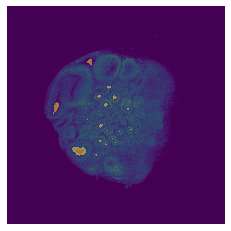

In [438]:
seg = io.imread(os.path.join(working_dir, 'dataset/segment_ventricles.tif'))
syto = io.imread(os.path.join(working_dir, 'dataset/syto_down6x.tif'))

plt.figure()
plt.imshow(syto[420])
plt.imshow(seg[420], alpha=0.5)
plt.axis('off')
plt.show()

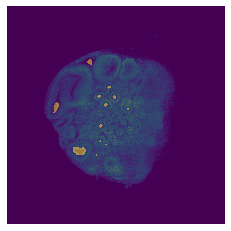

In [439]:
seg_smoothed = smooth_segmentation(seg, sigma=2) > 0.5

plt.figure()
plt.imshow(syto[420])
plt.imshow(seg_smoothed[420], alpha=0.5)
plt.axis('off')
plt.show()

Resize based on voxel size

In [440]:
downsample_factor = np.array([1, 6, 6])

voxel_orig = read_voxel_size(os.path.join(working_dir, 'dataset/voxel_size.csv'))
print(f'Original voxel size: {voxel_orig}')

voxel_down = tuple(voxel_orig * downsample_factor)
print(f'Downsampled voxel size: {voxel_down}')

voxel_isotropic = tuple(max(voxel_down) * np.ones(len(voxel_down)))
print(f'Isotropic voxel size: {voxel_isotropic}')

Original voxel size: (2.0, 0.651, 0.651)
Downsampled voxel size: (2.0, 3.906, 3.906)
Isotropic voxel size: (3.906, 3.906, 3.906)


In [441]:
factors = np.asarray(voxel_isotropic) / np.asarray(voxel_down)
shape_isotropic = tuple([int(s / f) for s, f in zip(seg_smoothed.shape, factors)])
foreground = resize(seg_smoothed, output_shape=shape_isotropic, order=0, preserve_range=True)

In [442]:
foreground = foreground > 0

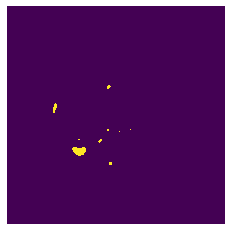

In [443]:
plt.figure()
plt.imshow(foreground[210])
plt.axis('off')
plt.show()

Label ventricle segmentation

In [444]:
labels = label(foreground)
labels.shape, f'Found {labels.max()} ventricles'

((460, 894, 894), 'Found 209 ventricles')

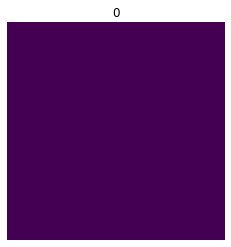

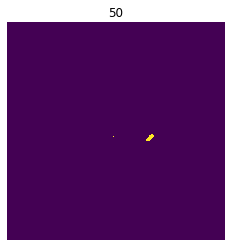

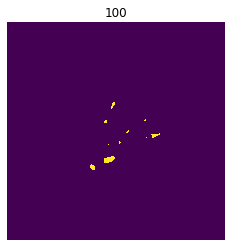

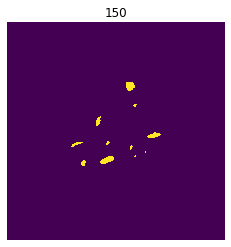

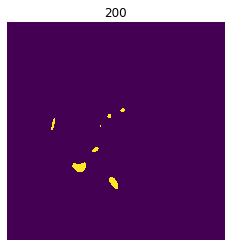

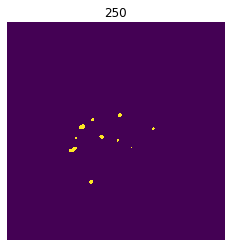

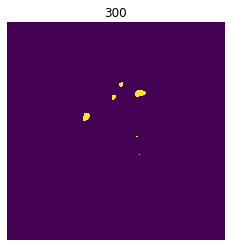

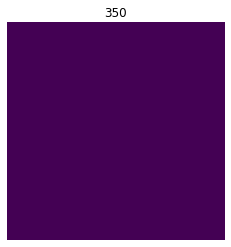

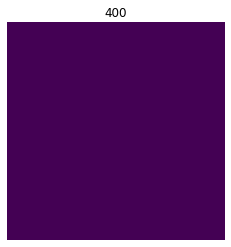

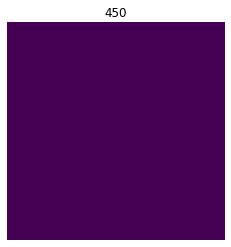

In [445]:
for z in range(0, labels.shape[0], 50):
    plt.figure()
    plt.imshow(labels[z], clim=[0, 1])
    plt.title(z)
    plt.axis('off')
    plt.show()

Compute morphological features

In [446]:
from skimage.measure import regionprops

In [447]:
regions = regionprops(labels)

In [448]:
volumes_pixels = np.asarray([region.area for region in regions])
eq_diams_pixels = np.asarray([region.equivalent_diameter for region in regions])
# major_axes_pixels = np.asarray([region.major_axis_length for region in regions])
# minor_axes_pixels = np.asarray([region.minor_axis_length for region in regions])

volumes_um3 = volumes_pixels * np.asarray(voxel_isotropic).prod()
eq_diams_um = eq_diams_pixels * voxel_isotropic[0]
# major_axes_um = major_axes_pixels * voxel_isotropic[0]
# minor_axes_um = minor_axes_pixels * voxel_isotropic[0]
# axis_ratios = major_axes_pixels / np.clip(minor_axes_pixels, 1, None)

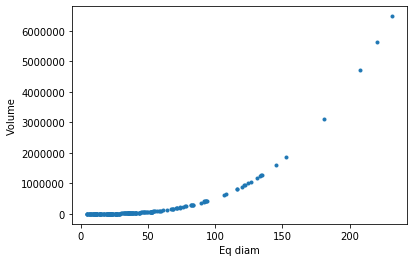

In [449]:
plt.plot(eq_diams_um, volumes_um3, '.')
plt.xlabel('Eq diam')
plt.ylabel('Volume')
plt.show()

## Compute cell counts in each profile

Load profiles and compute cell counts

In [450]:
profiles = np.load(os.path.join(working_dir, 'dataset/cyto_profiles.npy'))
cell_counts = profiles.sum(axis=-1)
cell_counts.shape

(86050, 3)

Get profile coordinates and match to ventricle

In [451]:
mesh = load_mesh(os.path.join(working_dir, 'dataset/mesh_ventricles.pkl'))
verts = mesh['verts']
verts.max(axis=0)

array([1233.8577, 2689.3213, 2515.7178], dtype=float32)

In [452]:
from skimage.morphology import binary_erosion

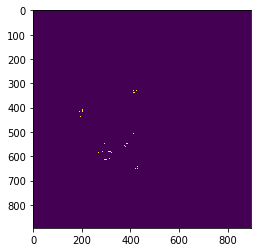

In [453]:
foreground_eroded = binary_erosion(foreground)
surface_image = np.logical_and(foreground, ~foreground_eroded)

%matplotlib inline
plt.figure()
plt.imshow(surface_image[210])
plt.show()

In [454]:
surface_coords = np.asarray(np.where(surface_image)).T
surface_um = surface_coords * voxel_isotropic
surface_um.max(axis=0)

array([1218.672, 2679.516, 2484.216])

In [455]:
from sklearn.neighbors import NearestNeighbors

In [456]:
nbrs = NearestNeighbors(n_neighbors=1).fit(surface_um)
distances, indices = nbrs.kneighbors(verts)
idx = indices[:, 0]
idx.shape

(86050,)

In [457]:
coords = surface_coords[idx]
coords.shape

(86050, 3)

In [458]:
coords_tuple = tuple([coords[:, i] for i in range(coords.shape[-1])])
ventricle_labels = labels[coords_tuple]
ventricle_labels.shape, f'All ventricles have matches? {ventricle_labels.max() == labels.max()}'

((86050,), 'All ventricles have matches? True')

In [459]:
ventricle_cell_counts = np.zeros((labels.max(), 3), np.int)
for lbl in range(1, labels.max()+1):
    idx = np.where(ventricle_labels == lbl)[0]
    counts = cell_counts[idx]
    ventricle_cell_counts[lbl-1] = counts.sum(axis=0)
ventricle_cell_counts.shape

(209, 3)

In [460]:
import pandas as pd
import seaborn as sns

In [461]:
celltype_names = read_csv(os.path.join(working_dir, 'dataset/celltype_names.csv'))
celltype_names

['sox2', 'tbr1', 'dn']

In [462]:
ventricle_cell_freq = (ventricle_cell_counts.T / ventricle_cell_counts.sum(axis=-1)).T
ventricle_cell_freq.shape

(209, 3)

In [463]:
data = dict(zip([c + '_count' for c in celltype_names], ventricle_cell_counts.T))
data.update(dict(zip([c + '_freq' for c in celltype_names], ventricle_cell_freq.T)))
df = pd.DataFrame(data)
df['eq_diam'] = eq_diams_um
df['volume'] = volumes_um3
df.head()

,sox2_count,tbr1_count,dn_count,sox2_freq,tbr1_freq,dn_freq,eq_diam,volume
0,13105,66301,13784,0.140627,0.711460,0.147913,52.494590,7.574296e+04
1,207092,1273231,316266,0.115270,0.708694,0.176037,207.954926,4.708757e+06
2,5234,18330,4360,0.187437,0.656425,0.156138,23.149496,6.495659e+03
3,131689,606456,82222,0.160524,0.739250,0.100226,122.021831,9.512863e+05
4,134371,1044917,523918,0.078893,0.613500,0.307607,220.656756,5.625360e+06


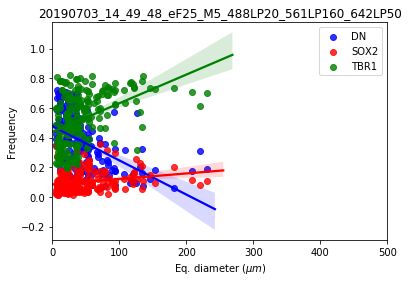

In [464]:
sns.regplot(x='eq_diam', y='dn_freq', data=df, label='DN', color='b')
sns.regplot(x='eq_diam', y='sox2_freq', data=df, label='SOX2', color='r')
sns.regplot(x='eq_diam', y='tbr1_freq', data=df, label='TBR1', color='g')
plt.xlim([0, 500])
plt.xlabel('Eq. diameter ($\mu m$)')
plt.ylabel('Frequency')
plt.title(working_dir.split('/')[-2])
plt.legend()
plt.show()

In [465]:
df.to_excel(os.path.join(working_dir, 'individual_ventricle_cellfreq.xlsx'))

## Compute cytoarchitecture frequencies and cell counts

Get cytoarchitecture labels and mesh vertices

In [ ]:
cyto_labels = np.load(os.path.join(working_dir, 'cyto_labels.npy'))
mesh = load_mesh(os.path.join(working_dir, 'dataset/mesh_ventricles.pkl'))

In [ ]:
verts = mesh['verts']
verts.max(axis=0)

In [ ]:
verts

Get the surface coordinates for the ventricle segmentation

In [ ]:
from skimage.morphology import binary_erosion

In [ ]:
foreground_eroded = binary_erosion(foreground)
surface_image = np.logical_and(foreground, ~foreground_eroded)

%matplotlib inline
plt.figure()
plt.imshow(surface_image[210])
plt.show()

In [ ]:
surface_coords = np.asarray(np.where(surface_image)).T
surface_coords.shape

In [ ]:
surface_um = surface_coords * voxel_isotropic
surface_um.max(axis=0)

Find the nearest ventricle label for each mesh vertex

In [ ]:
from sklearn.neighbors import NearestNeighbors

In [ ]:
nbrs = NearestNeighbors(n_neighbors=1).fit(surface_um)
nbrs

In [ ]:
distances, indices = nbrs.kneighbors(verts)
indices.shape, verts.shape

In [ ]:
idx = indices[:, 0]
idx.shape

In [ ]:
coords = surface_coords[idx]
coords.shape

In [ ]:
coords_tuple = tuple([coords[:, i] for i in range(coords.shape[-1])])
coords_tuple

In [ ]:
ventricle_labels = labels[coords_tuple]
ventricle_labels.shape

In [ ]:
f'All ventricles have matches? {ventricle_labels.max() == labels.max()}'

In [ ]:
all_cyto_labels = np.unique(cyto_labels)
all_cyto_labels

In [ ]:
fractions = []
for lbl in range(1, labels.max()+1):
    idx = np.where(ventricle_labels == lbl)[0]
    ventricle_cytos = cyto_labels[idx]
    counts = np.bincount(ventricle_cytos, minlength=max(all_cyto_labels)+1)
    fraction = counts / sum(counts)
    fractions.append(fraction)
fractions = np.array(fractions)
fractions.shape

In [ ]:
cyto_names = read_csv(os.path.join(working_dir, 'cyto_names.csv'))
cyto_names

In [ ]:
sort_idx = np.argsort(fractions[:, 2]) #.astype('str')
fractions[sort_idx, -1]

In [ ]:
import pandas as pd
import seaborn as sns

In [ ]:
frac_sum = np.cumsum(fractions, axis=-1)
frac_sum

In [ ]:
data = dict(zip(cyto_names, [frac_sum[sort_idx, i] for i in range(frac_sum.shape[-1])]))

In [ ]:
df = pd.DataFrame(data)
df.head()

In [ ]:
plt.figure()
colors = ['r', 'b', 'k', 'y', 'g', 'c']
for i in range(len(cyto_names)):
    sns.barplot(x=df.index, y=cyto_names[-i-1], data=df, color=colors[i], label=cyto_names[-i-1])
plt.axis('off')
plt.legend()
plt.show()

Cyto fractions vs venrtricle size

In [ ]:
%matplotlib inline
plt.figure()
for i, name in enumerate(cyto_names):
    plt.semilogx(eq_diams_um, fractions[:, i], '.', label=name)
plt.legend()
plt.xlabel('Eq. diameter (um)')
plt.ylabel('Fraction')
plt.show()

In [ ]:
data = dict(zip(cyto_names, [fractions[sort_idx, i] for i in range(frac_sum.shape[-1])]))
# data['idx'] = np.arange(119)
df = pd.DataFrame(data)
df.head()

In [ ]:
df['eq_diam'] = eq_diams_um
df['axis_ratio'] = axis_ratios
df['minor_axis'] = minor_axes_um
df['major_axis'] = major_axes_um
df['volume'] = volumes_um3
df.head()

In [ ]:
plt.figure(figsize=(6, 6))
for i, name in enumerate(cyto_names):
    sns.regplot(x='eq_diam', y=name, data=df, scatter_kws={'alpha': 0.7, 's': 10}, label=name)
plt.xlim([0, 200])
plt.ylim([0, 0.8])
plt.legend()
plt.show()

Add in distance to surface

In [ ]:
centers = np.asarray([region.centroid for region in regions]) * voxel_isotropic
centers.shape

In [ ]:
centers.max(axis=0)

In [ ]:
overall_seg = io.imread(os.path.join(working_dir, 'dataset/segment_foreground.tif')) > 0
overall_seg.shape

In [ ]:
overall_seg.max()

In [ ]:
org_surface = np.logical_and(overall_seg, ~binary_erosion(overall_seg))

In [ ]:
%matplotlib inline
plt.figure()
plt.imshow(org_surface[400])
plt.show()

In [ ]:
org_surf_coords = np.asarray(np.where(org_surface)).T * voxel_down
org_surf_coords.max(axis=0)

In [ ]:
nbrs = NearestNeighbors(n_neighbors=1).fit(org_surf_coords)
nbrs

In [ ]:
dist_surf, _ = nbrs.kneighbors(centers)

In [ ]:
df['dist'] = dist_surf
df.head()

In [ ]:
plt.figure(figsize=(6, 6))
for i, name in enumerate(cyto_names):
    sns.regplot(x='dist', y=name, data=df, scatter_kws={'alpha': 0.7, 's': 10}, label=name)
plt.xlim([100, 400])
plt.ylim([0, 0.8])
plt.xlabel('Distance to Surface')
plt.ylabel('Fraction')
plt.legend()
plt.show()

In [ ]:
sns.regplot(x='dist', y='eq_diam', data=df)

In [ ]:
df.to_excel(os.path.join(working_dir, 'individual_ventricle_cyto.xlsx'))